# Validation Layer

## **Description:**

- Now you have to create validation schema and produce simple model running on it
    - Create a validation class
    - Create a simpe model
    - Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage
    - Our validation results are very close to the production behaviour
    - We have enough validation data to rank our model results
- Prepare a simple picture that would describe your schema:
    - Decalre Train/Validation/Test splits
    - Define validation approach
    - Define the way you exrtact features that won't have target or data leakage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from skopt import BayesSearchCV

import sys
sys.path.append('../')
from scripts.validate import transform_df_types, TimeSeriesSplit, train_xgboost, train_linear_regression

## Load and transform **train** dataset

In [2]:
train_df = pd.read_csv('../data/result_train.csv')

In [3]:
float_columns = train_df.select_dtypes(include=np.number).columns.tolist()
object_columns = train_df.select_dtypes(include=object).columns.tolist()

train_df = transform_df_types(train_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0.0,2.0,27.0,1.0,2499.0,0.0,0.0,"007 Legends [PS3, русская версия]",19.0,Игры - PS3,...,0.000000,0.000000,31.0,2325.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,17.0,2.0,27.0,1.0,498.0,5.0,1.0,"007 Legends [PS3, русская версия]",19.0,Игры - PS3,...,1.742424,1.970149,30.0,498.000000,498.000000,0.0,998.0,0.0,998.0,1048.0
2,2.0,2.0,30.0,1.0,359.0,2.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40.0,Кино - DVD,...,1.136364,0.000000,31.0,388.716522,382.645966,0.0,0.0,0.0,0.0,0.0


## Describe a validation schema used:

The **TimeSeriesSplit** custom class is used to perform cross validation. It provides the implementation of "sliding window" and "expanding window" approaches for CV similar to sklearn.model_selection.TimeSeriesSplit class. Visual description of two CV methods with **n_splits = 5**:

![Expanding window](../images/Expanding.png "Expanding window TSCV")
![Sliding window](../images/Sliding.png "Sliding window TSCV")

### Check how **split(df)** with expanding window works

In [4]:
tscv = TimeSeriesSplit(n_splits=5, method='expanding')

for train_idx, test_idx in tscv.split(train_df):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 28.0
Test set months 29.0 29.0

Train set months: 0.0 29.0
Test set months 30.0 30.0

Train set months: 0.0 30.0
Test set months 31.0 31.0

Train set months: 0.0 31.0
Test set months 32.0 32.0

Train set months: 0.0 32.0
Test set months 33.0 33.0



### Check how **split(df)** with sliding window works

In [5]:
tscv = TimeSeriesSplit(n_splits=5, method='sliding')

for train_idx, test_idx in tscv.split(train_df):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 5.0
Test set months 6.0 6.0

Train set months: 6.0 11.0
Test set months 12.0 12.0

Train set months: 12.0 17.0
Test set months 18.0 18.0

Train set months: 18.0 23.0
Test set months 24.0 24.0

Train set months: 24.0 32.0
Test set months 33.0 33.0



## Clean train set from unneeded columns

In [6]:
train = train_df.select_dtypes(include=np.number)
y = train['item_cnt_month']
X = train.drop(['item_cnt_month', 'item_price', 'revenue', 'avg_item_price'], axis=1, inplace=False)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   month                           1608724 non-null  float32
 4   year                            1608724 non-null  float32
 5   item_category_id                1608724 non-null  float32
 6   months_since_last_sale          1608724 non-null  float32
 7   revenue_lag_1                   1608724 non-null  float32
 8   revenue_lag_2                   1608724 non-null  float32
 9   revenue_lag_3                   1608724 non-null  float32
 10  revenue_lag_6                   1608724 non-null  float32
 11  revenue_lag_12                  1608724 non-null  float32
 12  

### It's important to note, that before the training process we need to remove the **date_block_num** column

## Train and evaluate first model

In [9]:
train_linear_regression(X, y)

1 split RMSE: 2.02

2 split RMSE: 2.59

3 split RMSE: 2.47

4 split RMSE: 2.92

5 split RMSE: 3.14

Average RMSE: 2.63


## Use XGBoost with expanding window CV

In [28]:
train_xgboost(X, y)

1 split RMSE: 1.61

2 split RMSE: 1.42

3 split RMSE: 1.53

4 split RMSE: 1.84

5 split RMSE: 1.90

Average RMSE: 1.66


## Use XGBoost with sliding window

In [29]:
train_xgboost(X, y, cv_method='sliding', cv_n_splits=5)

1 split RMSE: 1.59

2 split RMSE: 1.65

3 split RMSE: 1.62

4 split RMSE: 1.74

5 split RMSE: 2.05

Average RMSE: 1.73


### As we can see, **sliding window validation** produces less **train data** in a single split which leads to a slightly bigger RMSE value

## Try deleting highly correlated features and check if this affects the model quality

We expect to see high correlation within each group of lagged features

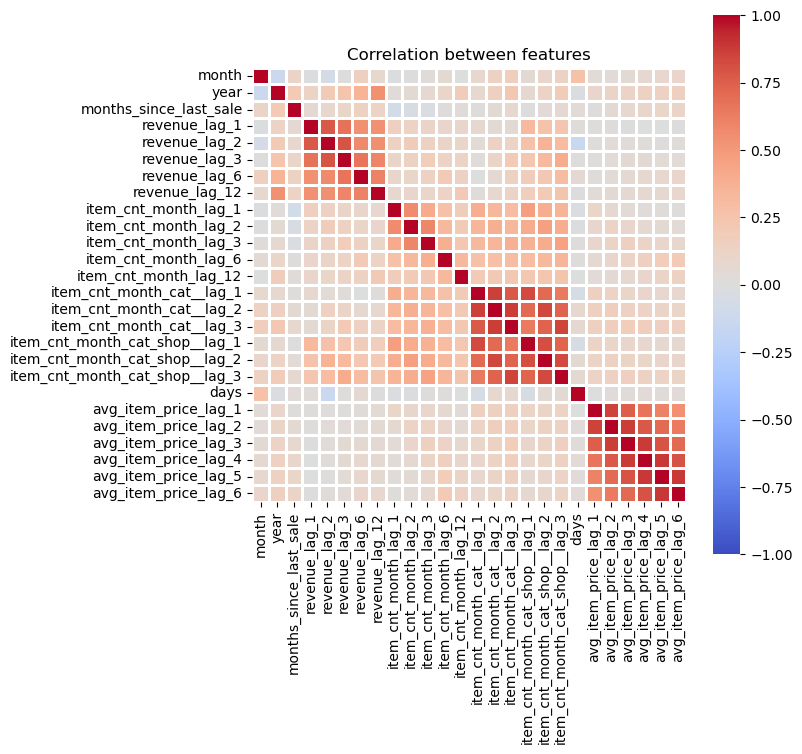

In [30]:
import seaborn as sns

numeric_train_df = X.copy()
numeric_train_df.drop(['date_block_num', 'item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
f, ax = plt.subplots()
f.set_size_inches(7, 7)
ax.set_title("Correlation between features")
sns.heatmap(numeric_train_df.corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=2, square=True);

In [31]:
X.columns

Index(['date_block_num', 'shop_id', 'item_id', 'month', 'year',
       'item_category_id', 'months_since_last_sale', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_cat_shop__lag_1',
       'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3',
       'days', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_6'],
      dtype='object')

In [32]:
X_less_corr = X.copy()
X_less_corr.drop(['revenue_lag_2', 'revenue_lag_3', 'item_cnt_month_cat__lag_2', 'item_cnt_month_cat__lag_3', 
                  'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3', 'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5'], axis=1, inplace=True)

In [33]:
model = train_xgboost(X_less_corr, y, return_model=True)

1 split RMSE: 1.61

2 split RMSE: 1.41

3 split RMSE: 1.51

4 split RMSE: 1.82

5 split RMSE: 1.90

Average RMSE: 1.65


### Deleting 9 highly-correlated features from the dataset didn't worsen the score (1.65 now vs 1.66 then). I will keep the dataset in this form for further work

## Before calculating feature importances, I'll tune hyperparameters of XGBoost model

I'll do this first because feature importance information is not relevant when measured on a bad model

In [ ]:
search_space = {
    'n_estimators': (300, 900),
    'max_depth': (3, 13),
    'learning_rate': (0.005, 0.3, 'log-uniform'),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0)
}

model = XGBRegressor(random_state=42)

cv_custom = TimeSeriesSplit(n_splits=3)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=15,
    cv=cv_custom,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

### I can't remove the **'date_block_num'** column from the dataset manually while the BayesSearchCV works, so I'll remove the **'month'** column instead - they are more or less equivalent

In [10]:
X_less_corr.drop(['month'], axis=1, inplace=True)
X_less_corr.head(3)

,date_block_num,shop_id,item_id,year,item_category_id,months_since_last_sale,revenue_lag_1,revenue_lag_6,revenue_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_cat__lag_1,item_cnt_month_cat_shop__lag_1,days,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_6
0,0.0,2.0,27.0,0.0,19.0,-1.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,31.0,0.000000,0.0,0.0
1,17.0,2.0,27.0,1.0,19.0,17.0,1395585.0,2865700.0,827343.9375,0.0,0.0,0.0,0.0,0.0,2.270404,2.000000,30.0,498.000000,0.0,1048.0
2,2.0,2.0,30.0,0.0,40.0,-1.0,522339.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.824838,1.052632,31.0,382.645966,0.0,0.0


In [12]:
results = []
bayes_search.fit(X_less_corr, y)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

results.append({
    'params': best_params,
    'cv_rmse': best_score,
})
print(f"Best CV negative RMSE = {best_score}")

results = sorted(results, key=lambda x: x['cv_rmse'], reverse=True)
print("Best parameters:", results[0]['params'])
print("Best CV negative RMSE:", results[0]['cv_rmse'])

Best CV negative RMSE = -1.7578519582748413
Best parameters: OrderedDict([('colsample_bytree', 0.8089836806604136), ('learning_rate', 0.04591510698786564), ('max_depth', 5), ('n_estimators', 619), ('subsample', 0.9643396182622281)])
Best CV negative RMSE: -1.7578519582748413


### 10 iterations results:

- [('colsample_bytree', 0.9249583953429453),
               ('learning_rate', 0.01794217698903441),
               ('max_depth', 10),
               ('n_estimators', 411),
               ('subsample', 0.8092209312217534)],
- 'cv_rmse': -1.7575781345367432

### 15 iterations results:

- [('colsample_bytree', 0.8089836806604136),
               ('learning_rate', 0.04591510698786564),
               ('max_depth', 5),
               ('n_estimators', 619),
               ('subsample', 0.9643396182622281)],
- 'cv_rmse': -1.7578519582748413

## Use the **first** set of parameters we got

In [34]:
model_best, scores = train_xgboost(X_less_corr, y, return_scores=True, return_model=True, cv_n_splits=5, n_estimators=411, learning_rate=0.01794, max_depth=10, subsample=0.8092, colsample_bytree=0.92496)

1 split RMSE: 1.61

2 split RMSE: 1.41

3 split RMSE: 1.52

4 split RMSE: 1.82

5 split RMSE: 1.91

Average RMSE: 1.65


## Use the **second** set of parameters we got

In [35]:
model_best, scores = train_xgboost(X_less_corr, y, return_scores=True, return_model=True, cv_n_splits=5, n_estimators=619, learning_rate=0.0459, max_depth=5, subsample=0.9643, colsample_bytree=0.8089)

1 split RMSE: 1.61

2 split RMSE: 1.43

3 split RMSE: 1.51

4 split RMSE: 1.82

5 split RMSE: 1.92

Average RMSE: 1.66


## Do the same search with the **original** dataset that contains correlated features removed in **X_less_corr** earlier

In [40]:
search_space = {
    'n_estimators': (300, 900),
    'max_depth': (3, 13),
    'learning_rate': (0.005, 0.3, 'log-uniform'),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0)
}

model = XGBRegressor(random_state=42)

cv_custom = TimeSeriesSplit(n_splits=3)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=15,
    cv=cv_custom,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

X_corr = X.drop(['month'], axis=1, inplace=False)

results = []
bayes_search.fit(X_corr, y)
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

results.append({
    'params': best_params,
    'cv_rmse': best_score,
})
print(f"Best CV negative RMSE = {best_score}")

results = sorted(results, key=lambda x: x['cv_rmse'], reverse=True)
print("Best parameters:", results[0]['params'])
print("Best CV negative RMSE:", results[0]['cv_rmse'])

/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best CV negative RMSE = -1.76011057694753
Best parameters: OrderedDict([('colsample_bytree', 0.939866032482152), ('learning_rate', 0.03005053095969883), ('max_depth', 8), ('n_estimators', 729), ('subsample', 0.971155621752006)])
Best CV negative RMSE: -1.76011057694753


- [
    ('colsample_bytree', 0.939866032482152),
    ('learning_rate', 0.03005053095969883), 
    ('max_depth', 8), ('n_estimators', 729), 
    ('subsample', 0.971155621752006)]
- 'cv_rmse': -1.76011057694753

## Use the parameters we got

In [41]:
model_best_with_corr, scores = train_xgboost(X, y, return_scores=True, return_model=True, cv_n_splits=5, n_estimators=729, learning_rate=0.03, max_depth=8, subsample=0.971, colsample_bytree=0.94)

1 split RMSE: 1.61

2 split RMSE: 1.42

3 split RMSE: 1.52

4 split RMSE: 1.81

5 split RMSE: 1.89

Average RMSE: 1.65


### These results (no improvement in score value) prove that the xgboost model with best parameters can't retrieve a single significant portion of extra information from the 9 correlated features I decided to keep in the dataset. So it's reasonable to use **X_less_corr** as the main one

## Try to use **XGBoost feature importance** information to find relevant features 

I will use the model left from the first XGBoost training process

In [42]:
from xgboost import plot_importance

def plot_features(booster, figsize, importance_type="weight"):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, importance_type=importance_type, values_format="{v:.2f}")

There are 3 ways of how the importance is calculated:
- ”weight” is the number of times a feature appears in a tree
- ”gain” is the average gain of splits which use the feature
- ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

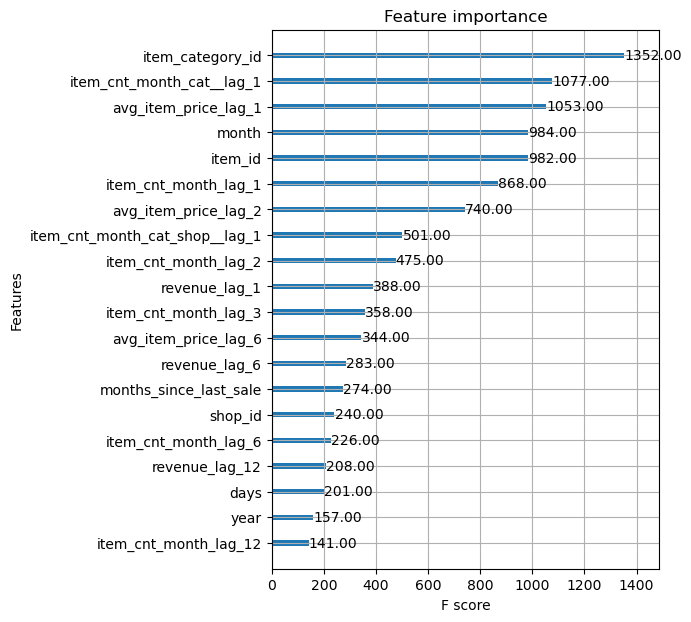

In [43]:
plot_features(model_best, (5, 7), importance_type="weight");

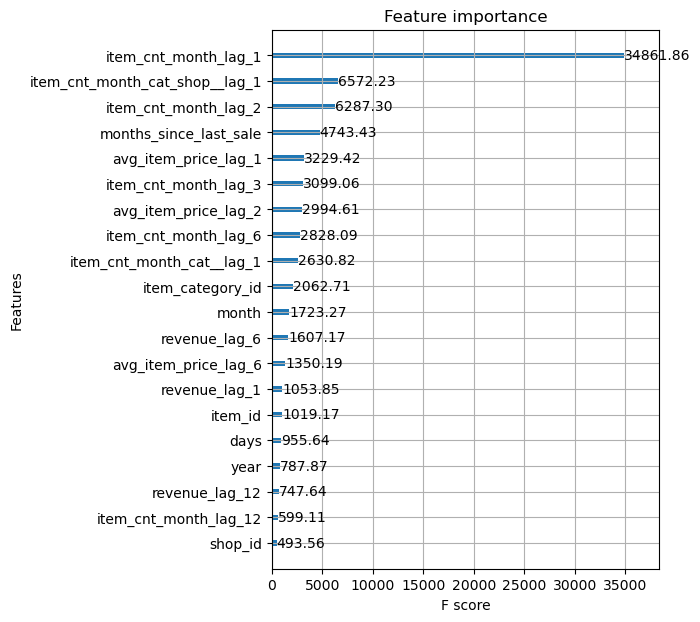

In [44]:
plot_features(model_best, (5, 7), importance_type="gain");

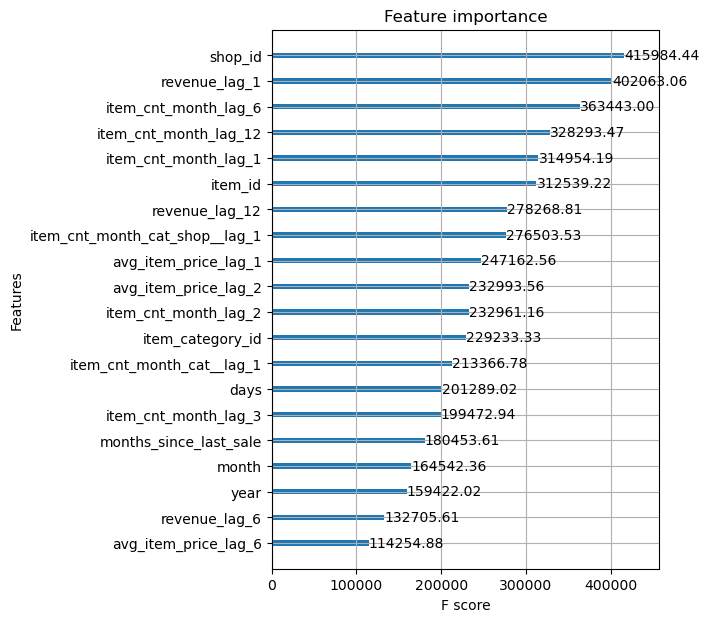

In [45]:
plot_features(model_best, (5, 7), importance_type="cover");

### All three graphs provide different answers; this means, that we need to determine which metric is the best for the dataset. I believe there are more accurate ways to calculate less biased feature importances 

## **Permutation** based feature importance

Permutation feature importance measures the increase in the prediction error of the model after we randomly shuffled the feature’s values

### First calculate X, y 

In [47]:
tscv = TimeSeriesSplit(n_splits=1)

for train_idx, test_idx in tscv.split(X_less_corr):
    X_new = X_less_corr.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [48]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model_best, X_test, y_test)

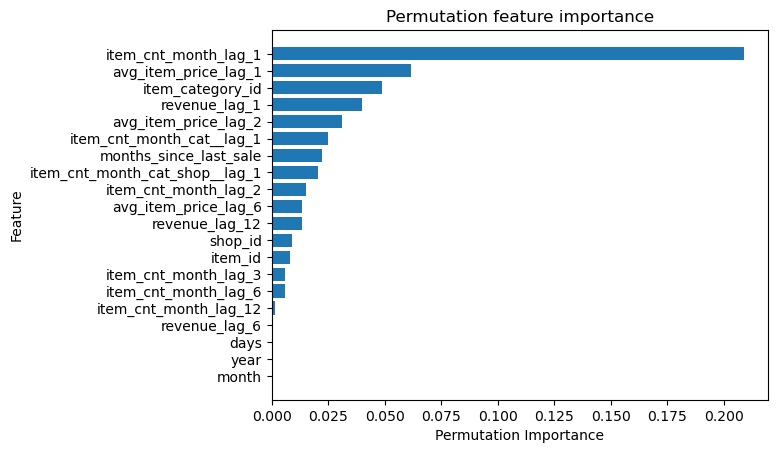

In [49]:
sorted_idx = perm.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm.importances_mean[sorted_idx])
plt.title("Permutation feature importance")
plt.ylabel("Feature");
plt.xlabel("Permutation Importance");

### Permutation-based method can be inaccurate with **highly correlated features** (it's still more or less a characteristic for our dataset because of some lagged features in it)

## **SHAP** is known to be one of the most consistent and accurate methods for calculating feature importances - let's use it now

In [50]:
import shap

explainer = shap.TreeExplainer(model_best, X_test)
shap_values = explainer(X_test)

100%|===================| 31408/31531 [02:56<00:00]        

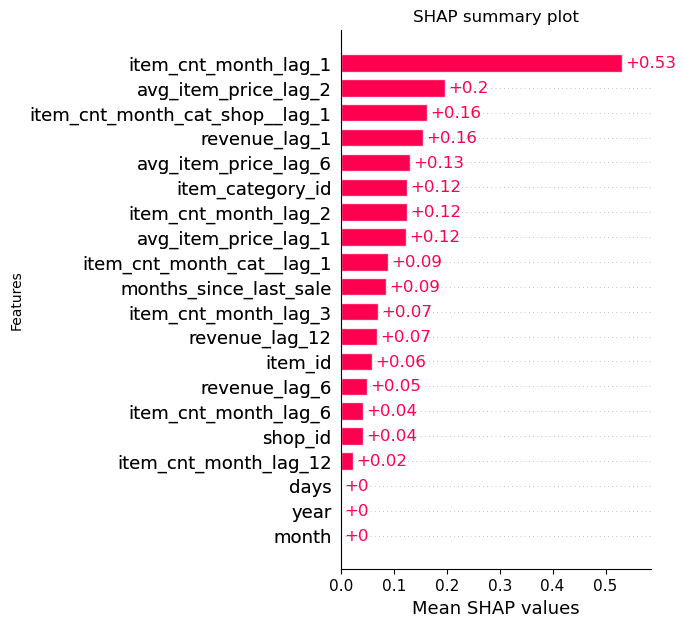

In [51]:
fig, ax = plt.subplots()

shap.plots.bar(shap_values, show=False, max_display=20)
fig.set_size_inches(4, 7)
ax.set_title("SHAP summary plot")
ax.set_xlabel("Mean SHAP values")
ax.set_ylabel("Features");

### Each bar represents the average impact of a corresponding feature on the model's prediction. This means that top features are the most influential in the decision-making process.

### SHAP and Permutation methods provide similar results on average: in both cases the most important feature is **"item_cnt_month_lag_1"**, while others don't stand out as much and, hence, may differ by 2-3 positions up or down. This difference might be also the result of permutation method dependence on the exact way the feature values were randomly shuffled. Running permutation a couple of times can easily lead to slightly different results.

### All in all, SHAP values have stronger math basis, so I will use them when working with other ML models

## Export the dataframes with numeric columns

In [53]:
X.to_csv('../data/numeric_train_with_corr.csv', index=False)
X_less_corr.to_csv('../data/numeric_train_without_corr.csv', index=False)

## **Conclusion:**

- defined a custom **TimeSeriesSplit** class for two methods of TS cross validation
- created a dataset of **numeric** columns to train the first model
- trained **LinearRegression** as a first model
- trained **XGBoostRegressor** model and used it as a base model for further work
- tried to **delete** some of the **highly correlated lagged features** to see if they add extra information to the model. Removing and adding these 9 features almost doesn't change the model quality at all
- performed **Bayesian hyperparameter tuning** for the xgboost model to use the best parameters model for calculating feature importances
- got the **best RMSE** CV average value of 1.65
- plotted feature importances of the xgboost model using 3 different methods: the built-in xgboost one, permutation and shap